# Computational Physics Tutorial 2 Number 1

Here we import all the packages we're goin to use throughout the tutorial

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import curve_fit

We first need to note that the underlying the distribution for the dataset is a normal distribution with a flat background B (which is described by the averrage number of entries in a bin of width 1). We also know that it is measured in 10 equidistant bins of x from 0 to 10. This distribution also has an unknown mean $\mu$ and stardard deviation $\sigma$ with a signal strength $S$. To compute the likelihood for a parameter $\left(S,\mu,\sigma,B\right)$ we also need to note an important fact, each bin in the Histogram represents a counting experiment. With this, we can immediately write out an expression for the expected number of events per bin: $$\left<N_i\right> = S \times \frac{1}{\sqrt{2\pi \sigma^2}}e^{-(x_i - \mu)/2\sigma^2} + B$$. 

Since each bin represents a counting experiment, we can conclude that each measurement in those bins follows a Poisson distribution:
$$P(N_i) = P(k=N_i; \lambda = \left<N_i\right>) = \frac{\lambda^k e^{-\lambda}}{k!}$$ 

And finally, the likelihood can computed using:
$$L(S, \mu, \sigma, B) = \prod^{n}_{i=1}P(N_i| S, \mu, \sigma, B)$$
which basically means we sub in the parameters into $\left<N_i\right>$ which we then use to calculate $P(N_i)$ for each bin and then multiply the results together to get the Likelihood associated with those parameters. The code below implements this.

In [3]:
bin_edge = np.linspace(1,10,10)    ## x range which is basically the bins
counts = np.array([1, 3, 6, 4, 6, 8, 1, 0, 1, 0])   ## Number of counts per bin
xs = np.linspace(0,10,1000)
bins = range(0,11)
b_width = 1
S = 20
B = 1
mu = 5
sigma = 2

#################################################################################################
#1a) defining the likelihood function and determining the likelihood with S=20,mu=5,sigma=2 & B=1 
#################################################################################################

def N_i(x,S,mean,std,B):         ## Defining a function for the probabilities of a guassian distribution
    Ni = S*(1/(np.sqrt(2*np.pi*(std)**2)))*np.exp(-((x-mean)**2)/(2*(std)**2)) + B*b_width
    return Ni

fx = N_i(bin_edge,S,mu,sigma,B)

def likely_h(S,mu,std,B,x,y):
    Ni = S*((1/(np.sqrt(2*np.pi*(std)**2)))*(np.exp(-((x-mu)**2)/(2*(std)**2)))) + B ## expected number of events per bin
    P = (Ni**(y))*np.exp(-Ni)/sp.special.factorial(y)   ## Assuming a finite binwidth, we use the Poisson Distribution
    lkhd = np.prod(P)           ## Multiply all the probabilities to get the likelyhood
    return lkhd

L = likely_h(S,mu,sigma,B,bin_edge,counts) 
print('The likelihood of S = 20, mu = 5, sigma = 2 and B = 1 is: ', L) #Not likely to be close to fit parameters

The likelihood of S = 20, mu = 5, sigma = 2 and B = 1 is:  7.281299399692929e-09


It's worth mentioning that there is a bin with zero counts. This raises an issue because we can no longer safely assume we have a continuous destribution but for the purposes of this Tutorial, we ignore that. To determine the parameter vector that best fits the measured data, we make use of one of the most famous optimazation packages python has to offer (curve_fit). We start out with our intitial guesses which are essentailly the parameters used above, $\vec{p} = (S=20, \mu = 5, \sigma = 2, B = 1)$. We then apply the curve_fit package outputs the parameters that best describe the measured data. The best-fit parameters are used compute the maximum likelihood by simply subtituting them into the likelihood function defined above and to generate the best-fit curve which is shown below. 

[34.43564904  4.53907771  2.02154373 -0.36364619]
Best-fit parameters:
S = 34.43564904493124
mu = 4.539077711452699
sigma = 2.0215437300857775
B = -0.36364619112946106
Likelihood: 1.4361549064206303e-07


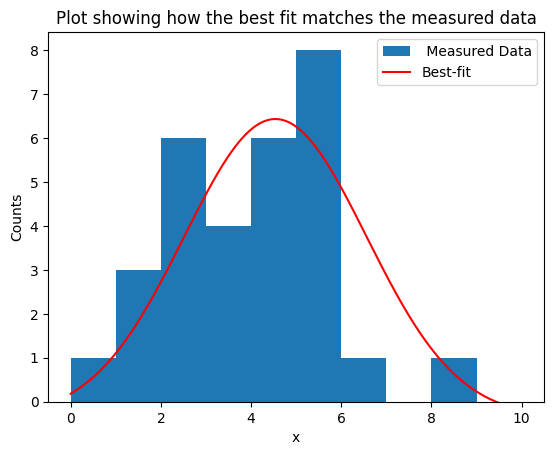

In [5]:
#################################################################################################
#1b) determining the parameters for the maximum likelihood and computing the maximum likelihood
#################################################################################################

# Define the histogram data
counts = np.array([1, 3, 6, 4, 6, 8, 1, 0, 1, 0])
centers = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
xdata = centers
ydata = counts

# Define initial guess for the parameters
params_guess = [20, 5, 2, 1]

# Fit the model to the data
popt, pcov = curve_fit(N_i, xdata, ydata, p0=params_guess)
print(popt)

# Print the best-fit parameters
print("Best-fit parameters:")
print("S =", popt[0])
print("mu =", popt[1])
print("sigma =", popt[2])
print("B =", popt[3])

# Calculate the likelihood for the best-fit parameters
ll = likely_h(popt[0], popt[1], popt[2], popt[3], centers, counts)
print("Maximum Likelihood:", ll)

# Plot the histogram and the best-fit model
plt.fill_between(bins, np.concatenate(([0],counts)), step="pre" ,label = ' Measured Data')
plt.plot(xs, N_i(xs, *popt), 'r-', label='Best-fit')
plt.legend()
plt.ylim(0)
plt.ylabel('Counts')
plt.xlabel('x')
plt.title('Plot showing how the best fit matches the measured data')
plt.show()


To discuss the uncertainty in the neighbourhood of the best fit, we simply need to visualize it using contour plots associated with signal strength S, standard deviation $\sigma$ and Background $B$  with respect to the mean $\mu$ such that either one parameter $S$ or $\sigma$ or $B$ is varied together with $\mu$ and keeping the other two constant as their best fit counter-parts.

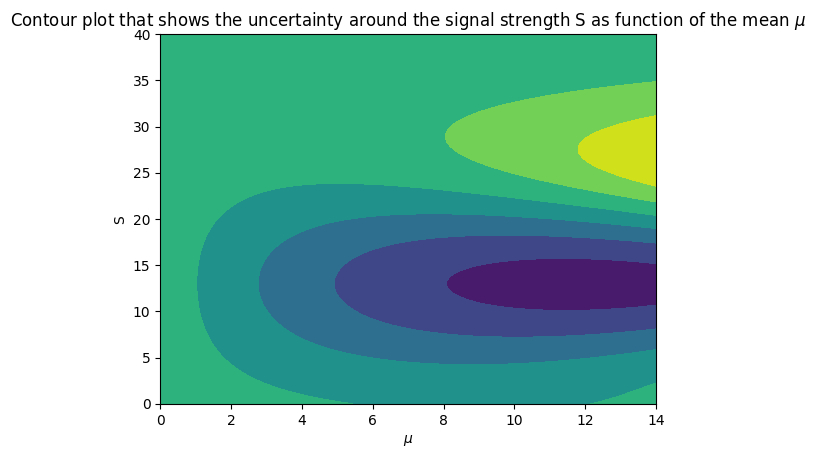

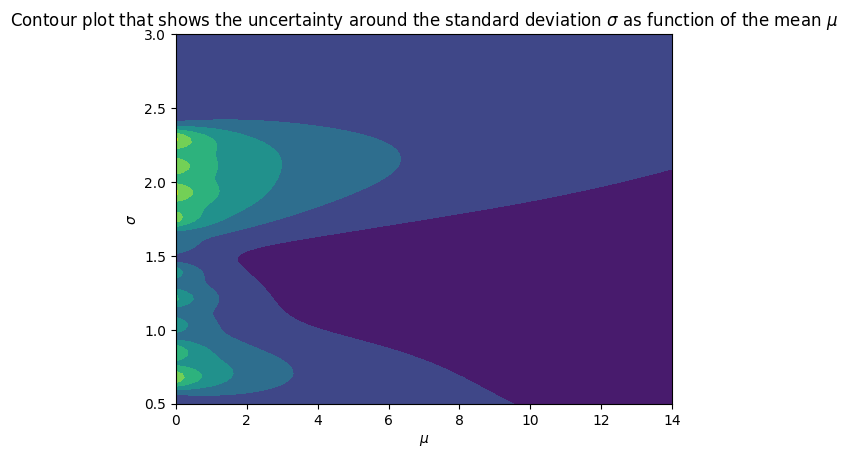

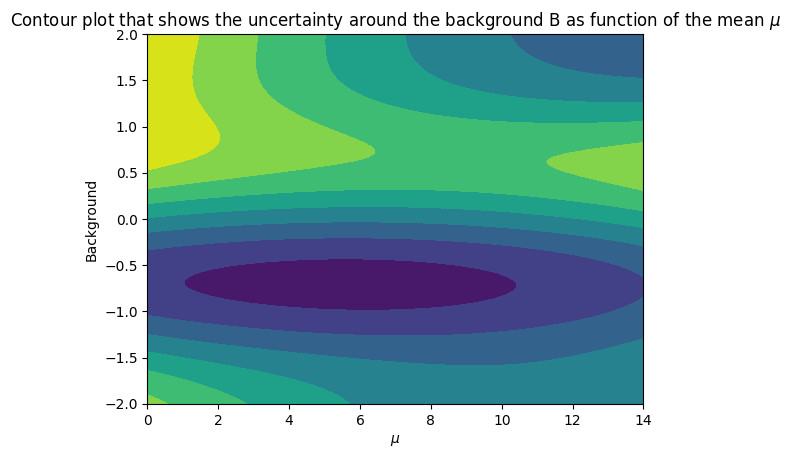

In [11]:
#################################################################################################
#1c) Visualising the uncertainty in the neighbourhood of the best fit
#################################################################################################

def chi(S,mu,sig,B):
    error = np.sum((counts-N_i(bin_edge, S, mu, sig, B))**2)
    return error

S_var = np.linspace(0,40,100)
u_var = np.linspace(0,14,100)
sig_var = np.linspace(0.5,3,100)
B_var = np.linspace(-2,2,100)
contour1 = np.zeros((len(S_var),len(u_var)))

# Contour Plot for The signal strength vs the mean so we keep both sigma and B constant as best-fit parameters
for ia,a in enumerate(S_var):
    for ib,b in enumerate(u_var):
        contour1[ib,ia] = chi(a, b, popt[2], popt[3])

plt.contourf(u_var,S_var,contour1)
plt.xlabel("$\mu$")
plt.ylabel("S")
plt.title("Contour plot that shows the uncertainty around the signal strength S as function of the mean $\mu$")
plt.show()

# Contour Plot for The sigma vs the mean so we keep both signal strength and B constant as best-fit parameters
contour2 = np.zeros((len(sig_var),len(u_var)))
for ia,a in enumerate(sig_var):
    for ib,b in enumerate(u_var):
        contour2[ib,ia] = chi(popt[0], b, a, popt[3])

plt.contourf(u_var,sig_var,contour2)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Contour plot that shows the uncertainty around the standard deviation $\sigma$ as function of the mean $\mu$")
plt.show()

# Contour Plot for The background vs the mean so we keep both signal strength and sigma as best-fit parameters
contour3 = np.zeros((len(B_var),len(u_var)))
for ia,a in enumerate(B_var):
    for ib,b in enumerate(u_var):
        contour3[ib,ia] = chi(popt[0], b, popt[2], a)

plt.contourf(u_var,B_var,contour3)
plt.xlabel("$\mu$")
plt.ylabel("Background")
plt.title("Contour plot that shows the uncertainty around the background B as function of the mean $\mu$")
plt.show()

We can cleary see that the uncertainty between $S$ and $\mu$ is minimal around $S=15$ and $8< \mu < 15$. The uncertainty between $\sigma$ and $\mu$ (I don't really know what this means). And finally, the uncertainty between $B$ and $\mu$ minimal $B=-0.25$ and $1< \mu < 10$ which focused around the best fit for both $B$ and $\mu$.